In [4]:
#pip install ortools

In [5]:
#pip install ortools geopy

In [42]:
from ortools.linear_solver import pywraplp
from geopy.distance import geodesic
import math

def calculate_distance_matrix(coords):  # 유클리드 거리 방식
    """Calculate the distance matrix using Euclidean distance."""
    size = len(coords)
    distance_matrix = [[0]*size for _ in range(size)]
    
    for i in range(size):
        for j in range(size):
            if i != j:
                lat1, lon1 = coords[i]
                lat2, lon2 = coords[j]
                distance_matrix[i][j] = math.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)  # Euclidean distance
            else:
                distance_matrix[i][j] = 0  # Same node distance is 0
    return distance_matrix

def solve_ctop(coords, scores, vehicle_count, vehicle_capacity, max_route_distance):
    distances = calculate_distance_matrix(coords)
    
    # Solver 생성
    solver = pywraplp.Solver.CreateSolver('CBC')
    if not solver:
        return None

    node_count = len(distances)
    K = vehicle_count
    N = node_count - 1  # 실제 노드 개수 (0번은 출발지/도착지)

    # 결정 변수
    x = {}
    y = {}
    for k in range(K):
        for i in range(node_count):
            for j in range(node_count):
                x[i, j, k] = solver.BoolVar(f'x_{i}_{j}_{k}')
        for i in range(node_count):
            y[i, k] = solver.BoolVar(f'y_{i}_{k}')

    # 목적 함수: 총 수집된 점수 최대화
    objective = solver.Objective()
    for k in range(K):
        for i in range(1, node_count):  # 0번 노드는 출발/도착지이므로 제외
            objective.SetCoefficient(y[i, k], scores[i])
    objective.SetMaximization()

    # 제약 조건 2, 3: 차량은 출발지에서 출발하고 다시 출발지로 돌아와야 함
    for k in range(K):
        solver.Add(solver.Sum(x[0, j, k] for j in range(1, node_count)) == 1)
        solver.Add(solver.Sum(x[i, 0, k] for i in range(1, node_count)) == 1)

    # 제약 조건 4: 각 노드는 최대 한 번만 방문됨
    for i in range(1, node_count):
        solver.Add(solver.Sum(x[i, j, k] for j in range(node_count) for k in range(K)) <= 1)
        solver.Add(solver.Sum(x[j, i, k] for j in range(node_count) for k in range(K)) <= 1)

    # 제약 조건 5: 각 차량의 용량 제한
    for k in range(K):
        solver.Add(solver.Sum(y[i, k] for i in range(1, node_count)) <= vehicle_capacity)

    # 제약 조건 6: 각 차량의 경로 길이는 최대 경로 길이를 초과하지 않음
    for k in range(K):
        solver.Add(solver.Sum(distances[i][j] * x[i, j, k] for i in range(node_count) for j in range(node_count)) <= max_route_distance)

    # 제약 조건 7: 부분 경로 제거 (MTZ 방법 사용)
    u = {}
    for k in range(K):
        for i in range(1, node_count):
            u[i, k] = solver.NumVar(0, node_count, f'u_{i}_{k}')

    for k in range(K):
        for i in range(1, node_count):
            for j in range(1, node_count):
                if i != j:
                    solver.Add(u[i, k] - u[j, k] + node_count * x[i, j, k] <= node_count - 1)

    # Solve the problem
    status = solver.Solve()

    # 결과 출력
    if status == pywraplp.Solver.OPTIMAL:
        print('Objective value:', solver.Objective().Value())
        for k in range(K):
            print(f'Vehicle {k+1} route:')
            route = []
            for i in range(node_count):
                for j in range(node_count):
                    if x[i, j, k].solution_value() > 0.5:
                        route.append((i, j))
            print(route)
    else:
        print('The problem does not have an optimal solution.')

# 예시 좌표 (위도, 경도)
coords = [
    (35.54889526514167, 129.2611903493333),  # 출발지/도착지
    (35.550219, 129.259635),  # 노드 1
    (35.544402, 129.255169),  # 노드 2
    (35.547098, 129.267564),  # 노드 3
    (35.542010, 129.272707),  # 노드 4
    (35.553232, 129.264393),  # 노드 5
    (35.549251, 129.251841),  # 노드 6
    (35.550680, 129.267493),   # 노드 7
    (35.550684, 129.267495),   # 노드 8
    (35.550987, 129.267498),   # 노드 9
    (35.550089, 129.267496),   # 노드 10
    (35.550085, 129.267494),   # 노드 11
    (35.550286, 129.267497)   # 노드 12
]

scores = [0, 10, 15, 20, 18, 25, 30, 12, 31, 17, 42, 43, 16]  # 각 노드의 점수
vehicle_count = 2
vehicle_capacity = 15
max_route_distance = 300  # 여기서는 km 단위


solve_ctop(coords, scores, vehicle_count, vehicle_capacity, max_route_distance)

Objective value: 558.0
Vehicle 1 route:
[(0, 12), (6, 0)]
Vehicle 2 route:
[(0, 1), (1, 0)]


0825

In [3]:
from ortools.linear_solver import pywraplp
import math

# 2D 좌표 간의 유클리드 거리 계산 함수
def euclidean_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

# 데이터 초기화

# 노드 세트 (0번은 출발지/도착지)
node_coords = {
    0: (10.0, 10.0),  # 출발지/도착지
    1: (12.0, 12.0),
    2: (15.0, 15.0),
    3: (18.0, 20.0),
    4: (20.0, 10.0),
    5: (25.0, 15.0),
    6: (10.0, 20.0),
    7: (30.0, 25.0),
    8: (5.0, 15.0),
    9: (25.0, 10.0),
    10: (20.0, 20.0),  # 추가된 노드
    11: (22.0, 18.0),  # 추가된 노드
    12: (24.0, 12.0),  # 추가된 노드
    13: (16.0, 14.0),  # 추가된 노드
    14: (30.0, 10.0)   # 추가된 노드
}

# 차량 세트
K = [0, 1]

# 고객 노드 세트 (출발지/도착지 제외)
S = [i for i in range(1, len(node_coords))]

# 노드 간 거리 (l) 계산
l = {}
for i in node_coords:
    for j in node_coords:
        if i != j:
            l[(i, j)] = euclidean_distance(node_coords[i], node_coords[j])

# 각 고객 노드의 점수 (s)
#s = {i: (i+1)*3 for i in range(len(node_coords))}
# 각 노드의 점수를 조정하여 특정 노드를 더 선호하도록 함
s = {
    0: 0, 1: 10, 2: 15, 3: 20, 4: 25, 
    5: 50, 6: 12, 7: 18, 8: 40, 9: 16, 
    10: 30, 11: 22, 12: 55, 13: 45, 14: 48, 15: 60
}  # 예를 들어, 노드 5, 8, 12, 15의 점수를 높게 설정

# 차량의 최대 용량 (Q)
Q = {0: 1000, 1: 1000}

# 차량의 최대 이동 거리 (L)
L = {0: 3000, 1: 3000}

# 각 노드의 수요 (d)
d = {i: (i+1)*3 for i in range(len(node_coords))}

# Solver 초기화
solver = pywraplp.Solver.CreateSolver('CBC')

# Decision Variables
x = {}
for i in node_coords:
    for j in node_coords:
        if i != j:
            for k in K:
                x[i, j, k] = solver.BoolVar(f'x[{i},{j},{k}]')

y = {}
for i in node_coords:
    for k in K:
        y[i, k] = solver.BoolVar(f'y[{i},{k}]')

# 각 노드를 방문할 때마다 추가 보너스를 주는 방식
# 차량이 방문한 노드 수에 비례하여 보너스를 부여
bonus_weight = 3 # 가중치 계수

# 페널티 항목 추가: 방문한 노드 수에 대한 페널티 부과
penalty_weight = 1000  # 페널티의 강도를 조절하는 가중치

# Objective Function 수정
solver.Maximize(
    solver.Sum(s[i] * y[i, k] for i in node_coords if i != 0 for k in K)  # 기본 점수
    + bonus_weight * solver.Sum(y[i, k] for i in node_coords if i != 0 for k in K)  # 보너스 점수
    - 0.1 * solver.Sum(l[i, j] * x[i, j, k] for i in node_coords for j in node_coords if i != j for k in K)  # 이동 거리
    - penalty_weight * solver.Sum((1 - solver.Sum(y[i, k] for i in node_coords if i != 0)) for k in K)  # 차량별 방문한 노드 수에 대한 페널티
)

# Objective Function (수정됨): 차량이 방문한 노드 수에 비례해 보너스를 주도록 수정
#solver.Maximize(
#    solver.Sum(s[i] * y[i, k] for i in node_coords if i != 0 for k in K)  # 기본 점수
#    + bonus_weight * solver.Sum(y[i, k] for i in node_coords if i != 0 for k in K)  # 보너스 점수
#    - 0.1 * solver.Sum(l[i, j] * x[i, j, k] for i in node_coords for j in node_coords if i != j for k in K)  # 이동 거리
#)

# Objective Function (1)
#solver.Maximize(solver.Sum(s[i] * y[i, k] for i in node_coords if i != 0 for k in K))
#solver.Maximize(solver.Sum(s[i] * y[i, k] for i in node_coords if i != 0 for k in K) 
#                - 0.1 * solver.Sum(l[i, j] * x[i, j, k] for i in node_coords for j in node_coords if i != j for k in K))


# Constraints

# Constraint (2) and (3): 모든 차량은 출발지에서 출발하고 도착지로 돌아와야 한다.
for k in K:
    solver.Add(solver.Sum(x[0, j, k] for j in node_coords if j != 0) == 1)
    solver.Add(solver.Sum(x[i, 0, k] for i in node_coords if i != 0) == 1)

# Constraint (4): 각 노드는 최대 한 번만 방문된다.
for i in node_coords:
    if i != 0:
        solver.Add(solver.Sum(y[i, k] for k in K) <= 1)
        
# 각 노드에 최소 하나의 차량이 방문하도록 강제
#for i in S:
#    solver.Add(solver.Sum(y[i, k] for k in K) >= 1)

# Constraint (5): 차량의 용량 제한
for k in K:
    solver.Add(solver.Sum(d[i] * y[i, k] for i in node_coords if i != 0) <= Q[k])

# Constraint (6): 차량의 최대 이동 거리 제한
for k in K:
    solver.Add(solver.Sum(l[i, j] * x[i, j, k] for i in node_coords for j in node_coords if i != j) <= L[k])

# 추가된 제약: 서브투어 제거
for k in K:
    for i in S:
        for j in S:
            if i != j:
                solver.Add(x[i, j, k] + x[j, i, k] <= 1)

# 노드의 방문 여부와 이동 사이의 관계 추가
for k in K:
    for i in node_coords:
        for j in node_coords:
            if i != j:
                solver.Add(x[i, j, k] <= y[i, k])
                solver.Add(x[i, j, k] <= y[j, k])
                solver.Add(y[i, k] + y[j, k] - 1 <= x[i, j, k])
                
# 모든 차량이 최소한 2개 이상의 노드를 방문하도록 제약
#for k in K:
#    solver.Add(solver.Sum(y[i, k] for i in S) >= 2)
    

# Solver 실행
status = solver.Solve()

# 결과 출력
if status == pywraplp.Solver.OPTIMAL:
    print('Optimal solution found:')
    total_score = 0
    for k in K:
        print(f'\nVehicle {k}:')

        # 경로 출력
        route = []
        for i in node_coords:
            for j in node_coords:
                if i != j and x[i, j, k].solution_value() > 0:
                    route.append((i, j))
        print(f'  Route: {route}')

        # 이동 거리 계산
        total_distance = sum(l[i, j] for i, j in route)
        print(f'  Total Distance: {total_distance}')

        # 차량이 얻은 점수 계산
        vehicle_score = sum(s[i] for i in node_coords if y[i, k].solution_value() > 0)
        total_score += vehicle_score
        print(f'  Score: {vehicle_score}')

        # 차량 부하 계산
        load = sum(d[i] for i in node_coords if y[i, k].solution_value() > 0)
        print(f'  Load: {load} (Capacity: {Q[k]})')

    print(f'\nTotal Score: {total_score}')
else:
    print('No optimal solution found.')


Optimal solution found:

Vehicle 0:
  Route: [(0, 5), (5, 0)]
  Total Distance: 31.622776601683793
  Score: 50
  Load: 21 (Capacity: 1000)

Vehicle 1:
  Route: [(0, 12), (12, 0)]
  Total Distance: 28.284271247461902
  Score: 55
  Load: 42 (Capacity: 1000)

Total Score: 105


0827

In [1]:
from ortools.linear_solver import pywraplp
import math

# 2D 좌표 간의 유클리드 거리 계산 함수
def euclidean_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

# 데이터 초기화

# 노드 세트 (0번은 출발지/도착지)
node_coords = {
    0: (10.0, 10.3),  # 출발지/도착지
    1: (10.5, 10.8),
    2: (11.0, 11.3),
    3: (12.0, 12.8),
    4: (12.5, 10.3),
    5: (13.0, 11.0),
    6: (10.2, 12.0),
    7: (13.5, 13.3),
    8: (9.5, 11.0),
    9: (12.8, 10.2),
    10: (12.0, 12.0),  # 추가된 노드
    11: (12.3, 11.8),  # 추가된 노드
    12: (12.7, 10.7),  # 추가된 노드
    13: (11.5, 11.2),  # 추가된 노드
    14: (13.3, 10.5)   # 추가된 노드
}

# 차량 세트
K = [0, 1]

# 고객 노드 세트 (출발지/도착지 제외)
S = [i for i in range(1, len(node_coords))]

# 노드 간 거리 (l) 계산
l = {}
for i in node_coords:
    for j in node_coords:
        if i != j:
            l[(i, j)] = euclidean_distance(node_coords[i], node_coords[j])

# 각 노드의 점수 (s)
s = {
    0: 0,   1: 12,  2: 14,  3: 18,  4: 22, 
    5: 42,  6: 15,  7: 20,  8: 38,  9: 18, 
    10: 28, 11: 24, 12: 48, 13: 40, 14: 44
}

# 차량의 최대 용량 (Q)
Q = {0: 1000, 1: 1000}

# 차량의 최대 이동 거리 (L)
L = {0: 3000, 1: 3000}

# 각 노드의 수요 (d)
d = {i: (i+1)*3 for i in range(len(node_coords))}

# Solver 초기화
solver = pywraplp.Solver.CreateSolver('CBC')

# Decision Variables
x = {}
for i in node_coords:
    for j in node_coords:
        if i != j:
            for k in K:
                x[i, j, k] = solver.BoolVar(f'x[{i},{j},{k}]')

y = {}
for i in node_coords:
    for k in K:
        y[i, k] = solver.BoolVar(f'y[{i},{k}]')


# Objective Function
solver.Maximize(
    solver.Sum(s[i] * y[i, k] for i in node_coords if i != 0 for k in K)  # 기본 점수
    # - 0.1 * solver.Sum(l[i, j] * x[i, j, k] for i in node_coords for j in node_coords if i != j for k in K)  # 이동 거리 최소화
    # + solver.Sum(y[i, k] for i in node_coords if i != 0 for k in K)  # 방문한 노드 수 최대화
    # - solver.Sum(1 - y[i, k] for i in S for k in K)  # 방문하지 않은 노드에 대한 페널티
)

# Constraints

# Constraint (2) and (3): 모든 차량은 출발지에서 출발하고 도착지로 돌아와야 한다.
for k in K:
    solver.Add(solver.Sum(x[0, j, k] for j in node_coords if j != 0) == 1)
    solver.Add(solver.Sum(x[i, 0, k] for i in node_coords if i != 0) == 1)

# Constraint (4): 각 노드는 최대 한 번만 방문된다.
for i in node_coords:
    if i != 0:
        solver.Add(solver.Sum(y[i, k] for k in K) <= 1)

# Constraint (5): 차량의 용량 제한
for k in K:
    solver.Add(solver.Sum(d[i] * y[i, k] for i in node_coords if i != 0) <= Q[k])

# Constraint (6): 차량의 최대 이동 거리 제한
for k in K:
   solver.Add(solver.Sum(l[i, j] * x[i, j, k] for i in node_coords for j in node_coords if i != j) <= L[k])


# 노드 방문 여부와 이동 간 관계 설정
for k in K:
    for i in node_coords:
        for j in node_coords:
            if i != j:
                solver.Add(x[i, j, k] <= y[i, k])
                solver.Add(x[i, j, k] <= y[j, k])
                solver.Add(y[i, k] + y[j, k] - 1 <= x[i, j, k])

# Flow conservation constraints: 방문한 노드는 반드시 떠나야 한다.
for k in K:
    for i in S:
        solver.Add(solver.Sum(x[i, j, k] for j in node_coords if i != j) == y[i, k])
        solver.Add(solver.Sum(x[j, i, k] for j in node_coords if i != j) == y[i, k])
        
# 서브투어 제거 제약 조건
for i in S:
    for j in S:
        if i != j:
            for k in K:
                solver.Add(x[i, j, k] + x[j, i, k] <= 1)

# Solver 실행
status = solver.Solve()

# 결과 출력
if status == pywraplp.Solver.OPTIMAL:
    print('Optimal solution found:')
    total_score = 0
    for k in K:
        print(f'\nVehicle {k}:')

        # 경로 출력
        route = []
        for i in node_coords:
            for j in node_coords:
                if i != j and x[i, j, k].solution_value() > 0:
                    route.append((i, j))
        print(f'  Route: {route}')

        # 이동 거리 계산
        total_distance = sum(l[i, j] for i, j in route)
        print(f'  Total Distance: {total_distance}')

        # 차량이 얻은 점수 계산
        vehicle_score = sum(s[i] for i in node_coords if y[i, k].solution_value() > 0)
        total_score += vehicle_score
        print(f'  Score: {vehicle_score}')

        # 차량 부하 계산
        load = sum(d[i] for i in node_coords if y[i, k].solution_value() > 0)
        print(f'  Load: {load} (Capacity: {Q[k]})')

    print(f'\nTotal Score: {total_score}')
else:
    print('No optimal solution found.')


Optimal solution found:

Vehicle 0:
  Route: [(0, 12), (12, 0)]
  Total Distance: 5.458937625582471
  Score: 48
  Load: 42 (Capacity: 1000)

Vehicle 1:
  Route: [(0, 14), (14, 0)]
  Total Distance: 6.612110101926617
  Score: 44
  Load: 48 (Capacity: 1000)

Total Score: 92


Optimal solution found:
Vehicle 0:
  Route: [0, 1, 5, 7, 14, 15, 18, 19, 0]
  Load: 28 (Capacity: 28)
  Total Distance: 82.93367853879023
  Score: 200
Vehicle 1:
  Route: [0, 2, 11, 13, 16, 17, 0]
  Load: 26 (Capacity: 28)
  Total Distance: 72.93191837530733
  Score: 148
Total Score: 348
Vehicle 0 load: 28.0 (Capacity: 28)
Vehicle 1 load: 26.0 (Capacity: 28)
Vehicle 0 distance: 28.653801254404698 (Max Distance: 30)
Vehicle 1 distance: 28.592092928850036 (Max Distance: 30)
Node 1 visited 1.0 time(s)
Node 2 visited 1.0 time(s)
Node 3 visited 0.0 time(s)
Node 4 visited 0.0 time(s)
Node 5 visited 1.0 time(s)
Node 6 visited 0.0 time(s)
Node 7 visited 1.0 time(s)
Node 8 visited 0.0 time(s)
Node 9 visited 0.0 time(s)
Node 10 visited 0.0 time(s)
Node 11 visited 1.0 time(s)
Node 12 visited 0.0 time(s)
Node 13 visited 1.0 time(s)
Node 14 visited 1.0 time(s)
Node 15 visited 1.0 time(s)
Node 16 visited 1.0 time(s)
Node 17 visited 1.0 time(s)
Node 18 visited 1.0 time(s)
Node 19 visited 1.0 time(s)


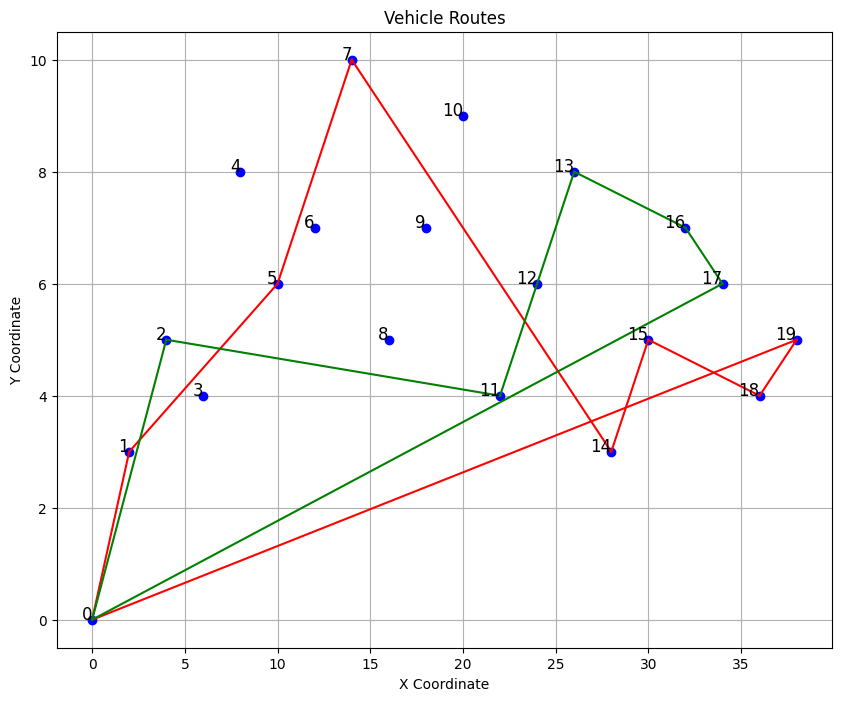

In [1]:
import math
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

def calculate_distances(coords):
    num_nodes = len(coords)
    distances = [[0] * num_nodes for _ in range(num_nodes)]
    for i in range(num_nodes):
        for j in range(num_nodes):
            distances[i][j] = math.sqrt((coords[i][0] - coords[j][0]) ** 2 + (coords[i][1] - coords[j][1]) ** 2)
    return distances

def plot_routes(coords, routes, num_vehicles):
    plt.figure(figsize=(10, 8))
    
    # 각 노드 (포인트)들을 그립니다
    for i, (x, y) in enumerate(coords):
        plt.plot(x, y, 'bo')  # 'bo'는 파란색 점으로 표시
        plt.text(x, y, f'{i}', fontsize=12, ha='right')
    
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']  # 차량별 색상 정의
    
    # 각 차량의 경로를 그립니다
    for k in range(num_vehicles):
        route = routes[k]
        for i in range(len(route) - 1):
            x1, y1 = coords[route[i]]
            x2, y2 = coords[route[i + 1]]
            plt.plot([x1, x2], [y1, y2], colors[k % len(colors)] + '-')  # '-'는 실선으로 표시
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routes')
    plt.grid(True)
    plt.show()

def solve_ctop(num_nodes, num_vehicles, distances, scores, demands, vehicle_capacity, max_distance, coords):
    # Create the solver
    solver = pywraplp.Solver.CreateSolver('CBC')

    # Variables
    x = {}  # x[i, j, k] : Vehicle k travels from node i to node j
    y = {}  # y[i, k] : Vehicle k visits node i
    for i in range(num_nodes):
        for j in range(num_nodes):
            for k in range(num_vehicles):
                x[i, j, k] = solver.BoolVar(f'x_{i}_{j}_{k}')
        for k in range(num_vehicles):
            y[i, k] = solver.BoolVar(f'y_{i}_{k}')

    # Objective: Maximize the score and minimize the travel distance
    solver.Maximize(
        solver.Sum(scores[i] * y[i, k] for i in range(1, num_nodes) for k in range(num_vehicles)) 
        - 0.1 * solver.Sum(distances[i][j] * x[i, j, k] for i in range(num_nodes) for j in range(num_nodes) for k in range(num_vehicles))
    )

    # Constraints

    # Each node is visited at most once
    for i in range(1, num_nodes):
        solver.Add(solver.Sum(y[i, k] for k in range(num_vehicles)) <= 1)

    # Vehicle capacity constraint
    for k in range(num_vehicles):
        solver.Add(solver.Sum(demands[i] * y[i, k] for i in range(1, num_nodes)) <= vehicle_capacity[k])

    # Maximum travel distance for each vehicle
    for k in range(num_vehicles):
        solver.Add(solver.Sum(distances[i][j] * x[i, j, k] for i in range(num_nodes) for j in range(num_nodes)) <= max_distance[k])

    # Flow conservation constraint
    for k in range(num_vehicles):
        for i in range(num_nodes):
            solver.Add(solver.Sum(x[i, j, k] for j in range(num_nodes) if j != i) == y[i, k])
            solver.Add(solver.Sum(x[j, i, k] for j in range(num_nodes) if j != i) == y[i, k])

    # Vehicles must start and end at the depot (node 0)
    for k in range(num_vehicles):
        solver.Add(solver.Sum(x[0, j, k] for j in range(1, num_nodes)) == 1)
        solver.Add(solver.Sum(x[i, 0, k] for i in range(1, num_nodes)) == 1)

    # Solve the problem
    status = solver.Solve()

    # Extract the solution
    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal solution found:')
        total_score = 0
        routes = []
        for k in range(num_vehicles):
            route = [0]  # 시작점 (Depot) 추가
            load = 0
            distance = 0
            for i in range(1, num_nodes):  # Depot는 건너뜁니다.
                if y[i, k].solution_value() > 0.5:
                    route.append(i)
                    load += demands[i]
            route.append(0)  # 종점 (Depot) 추가
            routes.append(route)

            for i in range(len(route) - 1):
                distance += distances[route[i]][route[i + 1]]
            total_score += sum(scores[i] for i in route)
            print(f'Vehicle {k}:')
            print(f'  Route: {route}')
            print(f'  Load: {load} (Capacity: {vehicle_capacity[k]})')
            print(f'  Total Distance: {distance}')
            print(f'  Score: {sum(scores[i] for i in route)}')
        print(f'Total Score: {total_score}')

        # ====================== #
        # 검증을 위한 추가 출력   #
        # ====================== #
        
        # 용량 제한 검토
        for k in range(num_vehicles):
            load = sum(demands[i] * y[i, k].solution_value() for i in range(num_nodes) if i != 0 and y[i, k].solution_value() > 0)
            print(f'Vehicle {k} load: {load} (Capacity: {vehicle_capacity[k]})')

        # 이동 거리 제한 검토
        for k in range(num_vehicles):
            distance = sum(distances[i][j] * x[i, j, k].solution_value() for i in range(num_nodes) for j in range(num_nodes) if i != j and x[i, j, k].solution_value() > 0)
            print(f'Vehicle {k} distance: {distance} (Max Distance: {max_distance[k]})')

        # 노드 방문 검토
        for i in range(num_nodes):
            if i != 0:
                visits = sum(y[i, k].solution_value() for k in range(num_vehicles))
                print(f'Node {i} visited {visits} time(s)')

        # 모든 차량이 출발지로 돌아왔는지 확인
        for k in range(num_vehicles):
            departs = sum(x[0, j, k].solution_value() for j in range(num_nodes) if j != 0)
            returns = sum(x[i, 0, k].solution_value() for i in range(num_nodes) if i != 0)
            print(f'Vehicle {k} departs: {departs} time(s), returns: {returns} time(s)')

        # 최적 경로 시각화
        plot_routes(coords, routes, num_vehicles)

    else:
        print('No optimal solution found.')

# 입력 데이터 정의
coords = [
    (0, 0),   # Depot
    (2, 3),   # Node 1
    (4, 5),   # Node 2
    (6, 4),   # Node 3
    (8, 8),   # Node 4
    (10, 6),  # Node 5
    (12, 7),  # Node 6
    (14, 10), # Node 7
    (16, 5),  # Node 8
    (18, 7),  # Node 9
    (20, 9),  # Node 10
    (22, 4),  # Node 11
    (24, 6),  # Node 12
    (26, 8),  # Node 13
    (28, 3),  # Node 14
    (30, 5),  # Node 15
    (32, 7),  # Node 16
    (34, 6),  # Node 17
    (36, 4),  # Node 18
    (38, 5)   # Node 19
]

# 거리 계산
distances = calculate_distances(coords)

# 문제 정의
num_nodes = len(coords)
num_vehicles = 2
scores = [0, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44]
demands = [0, 2, 3, 4, 5, 4, 6, 3, 7, 8, 6, 5, 9, 4, 3, 7, 8, 6, 5, 4]
vehicle_capacity = [28, 28]
max_distance = [30, 30]

# 문제 해결
solve_ctop(num_nodes, num_vehicles, distances, scores, demands, vehicle_capacity, max_distance, coords)


울산 남구 도산노인복지관 테스트(대현동, 신정4동, 야음장생포동)

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', '{:.10f}'.format)

# 도산노인복지관
shp_file_path_1 = "Data\남구 65세 이상 기초수급자 거주지(통신사비율보정) - 복사본\대현동 65세이상 기초수급자 거주지(통신사비율보정).shp"
shp_file_path_2 = "Data\남구 65세 이상 기초수급자 거주지(통신사비율보정) - 복사본\신정4동 65세이상 기초수급자 거주지(통신사비율보정).shp"
shp_file_path_3 = "Data\남구 65세 이상 기초수급자 거주지(통신사비율보정) - 복사본\야음장생포동 65세이상 기초수급자 거주지(통신사비율보정).shp"
df1 = gpd.read_file(shp_file_path_1, encoding='cp949')
df2 = gpd.read_file(shp_file_path_2, encoding='cp949')
df3 = gpd.read_file(shp_file_path_3, encoding='cp949')
df_Dosan = pd.concat([df1, df2, df3], axis=0)

# 문수실버복지관
shp_file_path_4 = "Data\남구 65세 이상 기초수급자 거주지(통신사비율보정) - 복사본\무거동 65세이상 기초수급자 거주지(통신사비율보정).shp"
shp_file_path_5 = "Data\남구 65세 이상 기초수급자 거주지(통신사비율보정) - 복사본\삼호동 65세이상 기초수급자 거주지(통신사비율보정).shp"
shp_file_path_6 = "Data\남구 65세 이상 기초수급자 거주지(통신사비율보정) - 복사본\옥동 65세이상 기초수급자 거주지(통신사비율보정).shp"
df4 = gpd.read_file(shp_file_path_4, encoding='cp949')
df5 = gpd.read_file(shp_file_path_5, encoding='cp949')
df6 = gpd.read_file(shp_file_path_6, encoding='cp949')
df_Moonsoo = pd.concat([df4, df5, df6], axis=0)

# 선암호수노인복지관
shp_file_path_7 = "Data\남구 65세 이상 기초수급자 거주지(통신사비율보정) - 복사본\선암동 65세이상 기초수급자 거주지(통신사비율보정).shp"
shp_file_path_8 = "Data\남구 65세 이상 기초수급자 거주지(통신사비율보정) - 복사본\수암동 65세이상 기초수급자 거주지(통신사비율보정).shp"
shp_file_path_9 = "Data\남구 65세 이상 기초수급자 거주지(통신사비율보정) - 복사본\신정2동 65세이상 기초수급자 거주지(통신사비율보정).shp"
df7 = gpd.read_file(shp_file_path_7, encoding='cp949')
df8= gpd.read_file(shp_file_path_8, encoding='cp949')
df9 = gpd.read_file(shp_file_path_9, encoding='cp949')
df_Seonam = pd.concat([df7, df8, df9], axis=0)

# 울산광역시노인복지관
shp_file_path_10 = "Data\남구 65세 이상 기초수급자 거주지(통신사비율보정) - 복사본\달동 65세이상 기초수급자 거주지(통신사비율보정).shp"
shp_file_path_11 = "Data\남구 65세 이상 기초수급자 거주지(통신사비율보정) - 복사본\삼산동 65세이상 기초수급자 거주지(통신사비율보정).shp"
shp_file_path_12 = "Data\남구 65세 이상 기초수급자 거주지(통신사비율보정) - 복사본\신정1동 65세이상 기초수급자 거주지(통신사비율보정).shp"
shp_file_path_13 = "Data\남구 65세 이상 기초수급자 거주지(통신사비율보정) - 복사본\신정3동 65세이상 기초수급자 거주지(통신사비율보정).shp"
shp_file_path_14 = "Data\남구 65세 이상 기초수급자 거주지(통신사비율보정) - 복사본\신정5동 65세이상 기초수급자 거주지(통신사비율보정).shp"
df10 = gpd.read_file(shp_file_path_10, encoding='cp949')
df11= gpd.read_file(shp_file_path_11, encoding='cp949')
df12 = gpd.read_file(shp_file_path_12, encoding='cp949')
df13= gpd.read_file(shp_file_path_13, encoding='cp949')
df14 = gpd.read_file(shp_file_path_14, encoding='cp949')
df_Ulsan = pd.concat([df10, df11, df12, df13, df14], axis=0)

shp_file_path_15 = "Data\남구 65세 이상 기초수급자 거주지(통신사비율보정) - 복사본\남구 65세이상 기초수급자(통산사비율보정).shp"
df_Namgu = gpd.read_file(shp_file_path_15, encoding='cp949')


df_Ulsan.head()

,aver_price,demand,geometry
0,398234.7937048064,8,POINT (129.32315 35.53336)
1,400807.3817762399,11,POINT (129.31656 35.53457)
2,484494.5299004689,14,POINT (129.31629 35.53353)
3,486928.1045751635,10,POINT (129.31655 35.53354)
4,500600.7208650381,64,POINT (129.31604 35.53488)


In [4]:
# 가중치 설정
weight_demand = 0.5
weight_price = 0.5

# 집값 기반 점수 계산 (집값이 낮을수록 높은 점수)
df_Dosan['price_score'] = 1 / df_Dosan['aver_price']
df_Moonsoo['price_score'] = 1 / df_Moonsoo['aver_price']
df_Seonam['price_score'] = 1 / df_Seonam['aver_price']
df_Ulsan['price_score'] = 1 / df_Ulsan['aver_price']

# 최종 우선순위 점수 계산
df_Dosan['priority_score'] = weight_demand * df_Dosan['demand'] + weight_price * df_Dosan['price_score']
df_Moonsoo['priority_score'] = weight_demand * df_Moonsoo['demand'] + weight_price * df_Moonsoo['price_score']
df_Seonam['priority_score'] = weight_demand * df_Seonam['demand'] + weight_price * df_Seonam['price_score']
df_Ulsan['priority_score'] = weight_demand * df_Ulsan['demand'] + weight_price * df_Ulsan['price_score']

# 결과 출력
df_Ulsan.head()
#df4.shape

,aver_price,demand,geometry,price_score,priority_score
0,398234.7937048064,8,POINT (129.32315 35.53336),0.0000025111,4.0000012555
1,400807.3817762399,11,POINT (129.31656 35.53457),0.0000024950,5.5000012475
2,484494.5299004689,14,POINT (129.31629 35.53353),0.0000020640,7.0000010320
3,486928.1045751635,10,POINT (129.31655 35.53354),0.0000020537,5.0000010268
4,500600.7208650381,64,POINT (129.31604 35.53488),0.0000019976,32.0000009988


In [5]:
# 노드 쪼개는 함수 정의 (우선순위 점수 유지)
def split_nodes_with_scores(df, max_demand=5):
    new_rows = []
    
    # 노드를 쪼개는 작업 수행
    for index, row in df.iterrows():
        demand = row['demand']
        if demand > max_demand:
            num_splits = (demand + max_demand - 1) // max_demand  # 쪼갤 노드 개수 계산
            for j in range(num_splits):
                new_demand = max_demand if j < num_splits - 1 else demand % max_demand or max_demand
                new_node = f"Node-{index+1}-{chr(97+j)}"  # a, b, c...로 노드 이름 변경
                new_rows.append({
                    'aver_price': row['aver_price'],
                    'demand': new_demand,
                    'geometry': row['geometry'],
                    'price_score': row['price_score'],
                    'priority_score': row['priority_score']
                })
        else:
            new_rows.append(row)
    
    return pd.DataFrame(new_rows)

# 노드 쪼개기 (우선순위 점수는 그대로 유지)
df_Dosan_split_final = split_nodes_with_scores(df_Dosan, max_demand=5)
df_Moonsoo_split_final = split_nodes_with_scores(df_Moonsoo, max_demand=5)
df_Seonam_split_final = split_nodes_with_scores(df_Seonam, max_demand=5)
df_Ulsan_split_final = split_nodes_with_scores(df_Ulsan, max_demand=5)

# 결과 출력
print(df_Ulsan_split_final.shape)
print(df_Ulsan_split_final.head())

(2406, 5)
         aver_price  demand                                     geometry  \
0 398234.7937048064       5  POINT (129.3231479432627 35.53335990012702)   
1 398234.7937048064       3  POINT (129.3231479432627 35.53335990012702)   
2 400807.3817762399       5  POINT (129.3165599799394 35.53456552879797)   
3 400807.3817762399       5  POINT (129.3165599799394 35.53456552879797)   
4 400807.3817762399       1  POINT (129.3165599799394 35.53456552879797)   

   price_score  priority_score  
0 0.0000025111    4.0000012555  
1 0.0000025111    4.0000012555  
2 0.0000024950    5.5000012475  
3 0.0000024950    5.5000012475  
4 0.0000024950    5.5000012475  


In [6]:
import math
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
import folium
import time
import numpy as np

In [8]:
def visualize_routes_on_map(coords, routes, num_vehicles):
    # 중앙 위치를 울산으로 설정
    m = folium.Map(location=[35.5299, 129.3299], zoom_start=13)

    # 차량 경로 색상을 설정
    colors = ['red', 'green', 'blue', 'purple', 'orange']
    
    # 경로를 지도에 추가
    for k, route in enumerate(routes):
        color = colors[k % len(colors)]
        
        # 경로의 각 지점을 PolyLine으로 연결하여 지도에 추가
        folium.PolyLine(
            locations=[(coords[node][1], coords[node][0]) for node in route],
            color=color,
            weight=5,
            opacity=0.7,
            popup=f'Vehicle {k} Route'
        ).add_to(m)
        
        # 각 노드에 마커 추가
        for node in route:
            folium.Marker(
                location=[coords[node][1], coords[node][0]],
                popup=f'Node {node}',
                icon=folium.Icon(color='blue' if node == 0 else 'green')
            ).add_to(m)
    
    # 지도를 출력
    return m

def calculate_distances(coords):
    num_nodes = len(coords)
    distances = [[0] * num_nodes for _ in range(num_nodes)]
    for i in range(num_nodes):
        for j in range(num_nodes):
            distances[i][j] = math.sqrt((coords[i][0] - coords[j][0]) ** 2 + (coords[i][1] - coords[j][1]) ** 2)
    return distances

def plot_routes(coords, routes, num_vehicles):
    plt.figure(figsize=(10, 8))
    
    # 각 노드 (포인트)들을 그립니다
    for i, (x, y) in enumerate(coords):
        plt.plot(x, y, 'bo')  # 'bo'는 파란색 점으로 표시
        plt.text(x, y, f'{i}', fontsize=12, ha='right')
    
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']  # 차량별 색상 정의
    
    # 각 차량의 경로를 그립니다
    for k in range(num_vehicles):
        route = routes[k]
        for i in range(len(route) - 1):
            x1, y1 = coords[route[i]]
            x2, y2 = coords[route[i + 1]]
            plt.plot([x1, x2], [y1, y2], colors[k % len(colors)] + '-')  # '-'는 실선으로 표시
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routes')
    plt.grid(True)
    plt.show()

def solve_ctop(num_nodes, num_vehicles, distances, scores, demands, vehicle_capacity, max_distance, coords):
    # 시작 시간 기록
    start_time = time.time()
    # Create the solver
    solver = pywraplp.Solver.CreateSolver('CBC')

    # Variables
    x = {}  # x[i, j, k] : Vehicle k travels from node i to node j
    y = {}  # y[i, k] : Vehicle k visits node i
    for i in range(num_nodes):
        for j in range(num_nodes):
            for k in range(num_vehicles):
                x[i, j, k] = solver.BoolVar(f'x_{i}_{j}_{k}')
        for k in range(num_vehicles):
            y[i, k] = solver.BoolVar(f'y_{i}_{k}')

    # Objective: Maximize the score and minimize the travel distance
    solver.Maximize(
    solver.Sum(scores[i] * y[i, k] for i in range(1, num_nodes) for k in range(num_vehicles)) 
    - 0.5 * solver.Sum(distances[i][j] * x[i, j, k] for i in range(num_nodes) for j in range(num_nodes) for k in range(num_vehicles))
    # + 1.5 * solver.Sum(1 / distances[i][j] * x[i, j, k] for i in range(num_nodes) for j in range(num_nodes) for k in range(num_vehicles) if i != j)
    )


    # Constraints

    # Each node is visited at most once
    for i in range(1, num_nodes):
        solver.Add(solver.Sum(y[i, k] for k in range(num_vehicles)) <= 1)

    # Vehicle capacity constraint
    for k in range(num_vehicles):
        solver.Add(solver.Sum(demands[i] * y[i, k] for i in range(1, num_nodes)) <= vehicle_capacity[k])

    # Maximum travel distance for each vehicle
    for k in range(num_vehicles):
        solver.Add(solver.Sum(distances[i][j] * x[i, j, k] for i in range(num_nodes) for j in range(num_nodes)) <= max_distance[k])

    # Flow conservation constraint
    for k in range(num_vehicles):
        for i in range(num_nodes):
            solver.Add(solver.Sum(x[i, j, k] for j in range(num_nodes) if j != i) == y[i, k])
            solver.Add(solver.Sum(x[j, i, k] for j in range(num_nodes) if j != i) == y[i, k])

    # Vehicles must start and end at the depot (node 0)
    for k in range(num_vehicles):
        solver.Add(solver.Sum(x[0, j, k] for j in range(1, num_nodes)) == 1)
        solver.Add(solver.Sum(x[i, 0, k] for i in range(1, num_nodes)) == 1)

    # Solve the problem
    status = solver.Solve()
    
    # 종료 시간 기록
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Extract the solution
    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal solution found:')
        total_score = 0
        routes = []
        for k in range(num_vehicles):
            route = [0]  # 시작점 (Depot) 추가
            load = 0
            distance = 0
            for i in range(1, num_nodes):  # Depot는 건너뜁니다.
                if y[i, k].solution_value() > 0.5:
                    route.append(i)
                    load += demands[i]
            route.append(0)  # 종점 (Depot) 추가
            routes.append(route)

            for i in range(len(route) - 1):
                distance += distances[route[i]][route[i + 1]]
            total_score += sum(scores[i] for i in route)
            print(f'Vehicle {k}:')
            print(f'  Route: {route}')
            print(f'  Load: {load} (Capacity: {vehicle_capacity[k]})')
            print(f'  Total Distance: {distance}')
            print(f'  Score: {sum(scores[i] for i in route)}')
        print(f'Total Score: {total_score}')
        
        # 최적해를 구하는데 걸린 시간 출력
        print(f"Time taken to find the optimal solution: {elapsed_time:.2f} seconds")

        # ====================== #
        # 검증을 위한 추가 출력   #
        # ====================== #
        
        # 용량 제한 검토
        for k in range(num_vehicles):
            load = sum(demands[i] * y[i, k].solution_value() for i in range(num_nodes) if i != 0 and y[i, k].solution_value() > 0)
            print(f'Vehicle {k} load: {load} (Capacity: {vehicle_capacity[k]})')

        # 이동 거리 제한 검토
        for k in range(num_vehicles):
            distance = sum(distances[i][j] * x[i, j, k].solution_value() for i in range(num_nodes) for j in range(num_nodes) if i != j and x[i, j, k].solution_value() > 0)
            print(f'Vehicle {k} distance: {distance} (Max Distance: {max_distance[k]})')

        # 노드 방문 검토
        for i in range(num_nodes):
            if i != 0:
                visits = sum(y[i, k].solution_value() for k in range(num_vehicles))
                print(f'Node {i} visited {visits} time(s)')

        # 모든 차량이 출발지로 돌아왔는지 확인
        for k in range(num_vehicles):
            departs = sum(x[0, j, k].solution_value() for j in range(num_nodes) if j != 0)
            returns = sum(x[i, 0, k].solution_value() for i in range(num_nodes) if i != 0)
            print(f'Vehicle {k} departs: {departs} time(s), returns: {returns} time(s)')

        # 지도 시각화
        m = visualize_routes_on_map(coords, routes, num_vehicles)
        display(m)

    else:
        print('No optimal solution found.')

# ============================= #
# df3 데이터를 활용한 문제 정의   #
# ============================= #

# df3 데이터를 priority_score 기준으로 정렬하고 상위 100개의 노드만 선택합니다.
df3_split_final_sorted = df3_split_final.sort_values(by='priority_score', ascending=False).head(100)
# df3_sorted = df3

# coords는 df3의 geometry에서 추출합니다. Depot 좌표 (129.3299, 35.5299)를 추가합니다.
coords = [(129.3299, 35.5299)] + [(point.x, point.y) for point in df3_split_final_sorted['geometry']]

# scores는 df3의 priority_score을 사용합니다.
scores = [0] + df3_split_final_sorted['priority_score'].tolist()  # Depot의 score는 0으로 설정

# demands는 df3의 demand를 사용합니다.
demands = [0] + df3_split_final_sorted['demand'].tolist()  # Depot의 demand는 0으로 설정

# 문제 정의
num_nodes = len(coords)
num_vehicles = 2
vehicle_capacity = [60, 60]
max_distance = [100, 100]

# 거리 계산
distances = calculate_distances(coords)

# 문제 해결
solve_ctop(num_nodes, num_vehicles, distances, scores, demands, vehicle_capacity, max_distance, coords)

Constraints method 적용

In [9]:
def visualize_routes_on_map(coords, routes, num_vehicles):
    # 중앙 위치를 울산으로 설정
    m = folium.Map(location=[35.5299, 129.3299], zoom_start=13)

    # 차량 경로 색상을 설정
    colors = ['red', 'green', 'blue', 'purple', 'orange']
    
    # 경로를 지도에 추가
    for k, route in enumerate(routes):
        color = colors[k % len(colors)]
        
        # 경로의 각 지점을 PolyLine으로 연결하여 지도에 추가
        folium.PolyLine(
            locations=[(coords[node][1], coords[node][0]) for node in route],
            color=color,
            weight=5,
            opacity=0.7,
            popup=f'Vehicle {k} Route'
        ).add_to(m)
        
        # 각 노드에 마커 추가
        for node in route:
            folium.Marker(
                location=[coords[node][1], coords[node][0]],
                popup=f'Node {node}',
                icon=folium.Icon(color='blue' if node == 0 else 'green')
            ).add_to(m)
    
    # 지도를 출력
    return m

def calculate_distances(coords):
    num_nodes = len(coords)
    distances = [[0] * num_nodes for _ in range(num_nodes)]
    for i in range(num_nodes):
        for j in range(num_nodes):
            distances[i][j] = math.sqrt((coords[i][0] - coords[j][0]) ** 2 + (coords[i][1] - coords[j][1]) ** 2)
    return distances

def plot_routes(coords, routes, num_vehicles):
    plt.figure(figsize=(10, 8))
    
    # 각 노드 (포인트)들을 그립니다
    for i, (x, y) in enumerate(coords):
        plt.plot(x, y, 'bo')  # 'bo'는 파란색 점으로 표시
        plt.text(x, y, f'{i}', fontsize=12, ha='right')
    
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']  # 차량별 색상 정의
    
    # 각 차량의 경로를 그립니다
    for k in range(num_vehicles):
        route = routes[k]
        for i in range(len(route) - 1):
            x1, y1 = coords[route[i]]
            x2, y2 = coords[route[i + 1]]
            plt.plot([x1, x2], [y1, y2], colors[k % len(colors)] + '-')  # '-'는 실선으로 표시
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routes')
    plt.grid(True)
    plt.show()


def solve_ctop_with_constraints(num_nodes, num_vehicles, distances, scores, demands, vehicle_capacity, max_distance, coords, min_score_constraint):
    # 시작 시간 기록
    start_time = time.time()
    # Create the solver
    solver = pywraplp.Solver.CreateSolver('CBC')

    # Variables
    x = {}  # x[i, j, k] : Vehicle k travels from node i to node j
    y = {}  # y[i, k] : Vehicle k visits node i
    for i in range(num_nodes):
        for j in range(num_nodes):
            for k in range(num_vehicles):
                x[i, j, k] = solver.BoolVar(f'x_{i}_{j}_{k}')
        for k in range(num_vehicles):
            y[i, k] = solver.BoolVar(f'y_{i}_{k}')

    # Objective: Minimize the travel distance
    solver.Minimize(
        solver.Sum(distances[i][j] * x[i, j, k] for i in range(num_nodes) for j in range(num_nodes) for k in range(num_vehicles))
    )

    # Constraints

    # 각 차량의 점수 제약 조건: 최소한 min_vehicle_score_constraint 이상이어야 합니다.
    for k in range(num_vehicles):
        vehicle_score = solver.Sum(scores[i] * y[i, k] for i in range(1, num_nodes))
        solver.Add(vehicle_score >= min_score_constraint)

    # 각 노드는 최대 한 번만 방문
    for i in range(1, num_nodes):
        solver.Add(solver.Sum(y[i, k] for k in range(num_vehicles)) <= 1)

    # 차량 용량 제한
    for k in range(num_vehicles):
        solver.Add(solver.Sum(demands[i] * y[i, k] for i in range(1, num_nodes)) <= vehicle_capacity[k])

    # 각 차량의 최대 이동 거리 제한
    for k in range(num_vehicles):
        solver.Add(solver.Sum(distances[i][j] * x[i, j, k] for i in range(num_nodes) for j in range(num_nodes)) <= max_distance[k])

    # 흐름 보존 제약 (Flow conservation constraint)
    for k in range(num_vehicles):
        for i in range(num_nodes):
            solver.Add(solver.Sum(x[i, j, k] for j in range(num_nodes) if j != i) == y[i, k])
            solver.Add(solver.Sum(x[j, i, k] for j in range(num_nodes) if j != i) == y[i, k])

    # 차량은 Depot (노드 0)에서 출발하고, 다시 돌아와야 합니다.
    for k in range(num_vehicles):
        solver.Add(solver.Sum(x[0, j, k] for j in range(1, num_nodes)) == 1)
        solver.Add(solver.Sum(x[i, 0, k] for i in range(1, num_nodes)) == 1)

    # 문제를 해결합니다.
    status = solver.Solve()

    # 종료 시간 기록
    end_time = time.time()
    elapsed_time = end_time - start_time

    # 해법 추출
    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal solution found:')
        total_score = 0
        routes = []
        for k in range(num_vehicles):
            route = [0]  # 시작점 (Depot) 추가
            load = 0
            distance = 0
            for i in range(1, num_nodes):  # Depot는 건너뜁니다.
                if y[i, k].solution_value() > 0.5:
                    route.append(i)
                    load += demands[i]
            route.append(0)  # 종점 (Depot) 추가
            routes.append(route)

            for i in range(len(route) - 1):
                distance += distances[route[i]][route[i + 1]]
            total_score += sum(scores[i] for i in route)
            print(f'Vehicle {k}:')
            print(f'  Route: {route}')
            print(f'  Load: {load} (Capacity: {vehicle_capacity[k]})')
            print(f'  Total Distance: {distance}')
            print(f'  Score: {sum(scores[i] for i in route)}')
        print(f'Total Score: {total_score}')

        # 최적해를 구하는데 걸린 시간 출력
        print(f"Time taken to find the optimal solution: {elapsed_time:.2f} seconds")

        # 지도 시각화
        m = visualize_routes_on_map(coords, routes, num_vehicles)
        display(m)
    else:
        print('No optimal solution found.')


# ============================= #
# df4 데이터를 활용한 문제 정의   #
# ============================= #

# df4 데이터를 priority_score 기준으로 정렬하고 상위 100개의 노드만 선택합니다.
df_Dosan_split_final_sorted = df_Dosan_split_final.sort_values(by='priority_score', ascending=False).head(100)

# coords는 df4의 geometry에서 추출합니다. Depot 좌표 (129.3299, 35.5299)를 추가합니다.
coords = [(129.3299, 35.5299)] + [(point.x, point.y) for point in df_Dosan_split_final_sorted['geometry']]

# scores는 df4의 priority_score을 사용합니다.
scores = [0] + df_Dosan_split_final_sorted['priority_score'].tolist()  # Depot의 score는 0으로 설정

# demands는 df4의 demand를 사용합니다.
demands = [0] + df_Dosan_split_final_sorted['demand'].tolist()  # Depot의 demand는 0으로 설정

# 문제 정의
num_nodes = len(coords)
num_vehicles = 3
vehicle_capacity = [70, 70, 70]
max_distance = [100, 100, 100]

# 거리 계산
distances = calculate_distances(coords)

# 최소 점수 제약 설정
min_score_constraint = 400

# 문제 해결
solve_ctop_with_constraints(num_nodes, num_vehicles, distances, scores, demands, vehicle_capacity, max_distance, coords, min_score_constraint)

Optimal solution found:
Vehicle 0:
  Route: [0, 7, 10, 12, 13, 14, 16, 17, 18, 25, 30, 33, 43, 45, 100, 0]
  Load: 70 (Capacity: 70)
  Total Distance: 0.04914007899681441
  Score: 408.0000059670881
Vehicle 1:
  Route: [0, 1, 3, 21, 22, 27, 29, 31, 32, 34, 36, 37, 40, 47, 99, 0]
  Load: 70 (Capacity: 70)
  Total Distance: 0.04914007899681441
  Score: 407.00000542388784
Vehicle 2:
  Route: [0, 4, 5, 6, 8, 9, 11, 15, 19, 20, 23, 26, 28, 35, 42, 0]
  Load: 66 (Capacity: 70)
  Total Distance: 0.048424259009570196
  Score: 419.00000621124053
Total Score: 1234.0000176022165
Time taken to find the optimal solution: 13.20 seconds


4개 복지관 경로 합치기

In [58]:
import osmnx as ox
import networkx as nx
import folium
import branca.colormap as cm

In [71]:
from sklearn.preprocessing import MinMaxScaler

def visualize_all_routes_on_map(all_coords, all_routes, depot_locations, df_Namgu):
    # 전체 경로에서 첫 번째 Depot 좌표를 기준으로 지도 생성
    m = folium.Map(location=depot_locations[0], zoom_start=12)

    # 차량 경로 색상을 설정 (색상 리스트를 충분히 확장)
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'darkred', 'lightgreen', 'pink', 'black', 'lightblue']
    
    # 각 데이터셋의 경로를 지도에 추가
    for idx, (coords, routes) in enumerate(zip(all_coords, all_routes)):
        for k, route in enumerate(routes):
            color = colors[(idx * len(routes) + k) % len(colors)]  # 데이터셋별로 색상 구분
            
            # 경로의 각 지점을 PolyLine으로 연결하여 지도에 추가
            folium.PolyLine(
                locations=[(coords[node][1], coords[node][0]) for node in route],
                color=color,
                weight=5,
                opacity=0.7,
                popup=f'Dataset {idx + 1}, Vehicle {k} Route'
            ).add_to(m)
            
            # 각 노드에 마커 추가
            for node in route:
                folium.Marker(
                    location=[coords[node][1], coords[node][0]],
                    popup=f'Dataset {idx + 1}, Node {node}',
                    icon=folium.Icon(color='blue' if node == 0 else 'green')
                ).add_to(m)
    
    # df3의 집값 데이터를 CircleMarker로 지도에 추가
    df_Namgu['coords'] = df_Namgu['geometry'].apply(lambda x: (x.y, x.x))
    
    # 환율 설정 (예: 1 달러 = 1300 원)
    exchange_rate = 1300
    
    # 가격을 원화에서 달러로 변환
    df_Namgu['aver_price_usd'] = df_Namgu['aver_price'] / exchange_rate

    # 최소-최대 스케일링을 사용하여 집값을 0과 1 사이로 변환
    scaler = MinMaxScaler()
    df_Namgu['scaled_price'] = scaler.fit_transform(df_Namgu[['aver_price_usd']])

    # 컬러맵 생성 (집 값이 저렴할수록 빨간색, 비쌀수록 초록색)
    min_price = df_Namgu['aver_price_usd'].min()
    max_price = df_Namgu['aver_price_usd'].max()

    # 집값 범위에 따른 색상 표시
    colormap = cm.LinearColormap(colors=['red', 'yellow', 'green'], vmin=min_price, vmax=max_price)

    # df3의 데이터를 CircleMarker로 지도에 추가 (달러 단위로 가격)
    for idx, row in df_Namgu.iterrows():
        color = colormap(row['aver_price_usd'])  # 실제 달러 가격을 기반으로 색상 적용
        folium.CircleMarker(
            location=row['coords'],
            radius=3,  # 반경 설정
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"Price: ${row['aver_price_usd']:.2f}"
        ).add_to(m)

    # 범례는 달러 기준으로 표시
    colormap.caption = 'House Prices in USD'
    m.add_child(colormap)

    # 지도를 반환
    return m


# def visualize_all_routes_on_map(all_coords, all_routes, depot_locations):
#     # 전체 경로에서 첫 번째 Depot 좌표를 기준으로 지도 생성
#     m = folium.Map(location=depot_locations[0], zoom_start=12)

#     # 차량 경로 색상을 설정 (색상 리스트를 충분히 확장)
#     colors = ['red', 'green', 'blue', 'purple', 'orange', 'darkred', 'lightgreen', 'pink', 'black', 'lightblue']
    
#     # 각 데이터셋의 경로를 지도에 추가
#     for idx, (coords, routes) in enumerate(zip(all_coords, all_routes)):
#         for k, route in enumerate(routes):
#             color = colors[(idx * len(routes) + k) % len(colors)]  # 데이터셋별로 색상 구분
            
#             # 경로의 각 지점을 PolyLine으로 연결하여 지도에 추가
#             folium.PolyLine(
#                 locations=[(coords[node][1], coords[node][0]) for node in route],
#                 color=color,
#                 weight=5,
#                 opacity=0.7,
#                 popup=f'Dataset {idx + 1}, Vehicle {k} Route'
#             ).add_to(m)
            
#             # 각 노드에 마커 추가
#             for node in route:
#                 folium.Marker(
#                     location=[coords[node][1], coords[node][0]],
#                     popup=f'Dataset {idx + 1}, Node {node}',
#                     icon=folium.Icon(color='blue' if node == 0 else 'green')
#                 ).add_to(m)
    
#     # 지도를 반환
#     return m


def calculate_distances(coords):
    num_nodes = len(coords)
    distances = [[0] * num_nodes for _ in range(num_nodes)]
    for i in range(num_nodes):
        for j in range(num_nodes):
            distances[i][j] = math.sqrt((coords[i][0] - coords[j][0]) ** 2 + (coords[i][1] - coords[j][1]) ** 2)
    return distances

def plot_routes(coords, routes, num_vehicles):
    plt.figure(figsize=(10, 8))
    
    # 각 노드 (포인트)들을 그립니다
    for i, (x, y) in enumerate(coords):
        plt.plot(x, y, 'bo')  # 'bo'는 파란색 점으로 표시
        plt.text(x, y, f'{i}', fontsize=12, ha='right')
    
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']  # 차량별 색상 정의
    
    # 각 차량의 경로를 그립니다
    for k in range(num_vehicles):
        route = routes[k]
        for i in range(len(route) - 1):
            x1, y1 = coords[route[i]]
            x2, y2 = coords[route[i + 1]]
            plt.plot([x1, x2], [y1, y2], colors[k % len(colors)] + '-')  # '-'는 실선으로 표시
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routes')
    plt.grid(True)
    plt.show()


def solve_ctop_with_constraints(num_nodes, num_vehicles, distances, scores, demands, vehicle_capacity, max_distance, coords, min_score_constraint):
    # 시작 시간 기록
    start_time = time.time()
    
    # Create the solver
    solver = pywraplp.Solver.CreateSolver('CBC')

    # Variables
    x = {}
    y = {}
    for i in range(num_nodes):
        for j in range(num_nodes):
            for k in range(num_vehicles):
                x[i, j, k] = solver.BoolVar(f'x_{i}_{j}_{k}')
        for k in range(num_vehicles):
            y[i, k] = solver.BoolVar(f'y_{i}_{k}')

    # Objective: Minimize the travel distance
    solver.Minimize(
        solver.Sum(distances[i][j] * x[i, j, k] for i in range(num_nodes) for j in range(num_nodes) for k in range(num_vehicles))
    )

    # Constraints
    for k in range(num_vehicles):
        vehicle_score = solver.Sum(scores[i] * y[i, k] for i in range(1, num_nodes))
        solver.Add(vehicle_score >= min_score_constraint)

    for i in range(1, num_nodes):
        solver.Add(solver.Sum(y[i, k] for k in range(num_vehicles)) <= 1)

    for k in range(num_vehicles):
        solver.Add(solver.Sum(demands[i] * y[i, k] for i in range(1, num_nodes)) <= vehicle_capacity[k])

    for k in range(num_vehicles):
        solver.Add(solver.Sum(distances[i][j] * x[i, j, k] for i in range(num_nodes) for j in range(num_nodes)) <= max_distance[k])

    for k in range(num_vehicles):
        for i in range(num_nodes):
            solver.Add(solver.Sum(x[i, j, k] for j in range(num_nodes) if j != i) == y[i, k])
            solver.Add(solver.Sum(x[j, i, k] for j in range(num_nodes) if j != i) == y[i, k])

    for k in range(num_vehicles):
        solver.Add(solver.Sum(x[0, j, k] for j in range(1, num_nodes)) == 1)
        solver.Add(solver.Sum(x[i, 0, k] for i in range(1, num_nodes)) == 1)

    # 문제를 해결합니다.
    status = solver.Solve()

    # 종료 시간 기록
    end_time = time.time()
    elapsed_time = end_time - start_time

    routes = []  # 각 차량의 경로를 저장할 리스트

    # 해법 추출
    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal solution found:')
        for k in range(num_vehicles):
            route = [0]  # 시작점 (Depot) 추가
            for i in range(1, num_nodes):  # Depot는 건너뜁니다.
                if y[i, k].solution_value() > 0.5:
                    route.append(i)
            route.append(0)  # 종점 (Depot) 추가
            routes.append(route)

        print(f"Time taken to find the optimal solution: {elapsed_time:.2f} seconds")
    else:
        print('No optimal solution found.')

    return routes  # 경로 데이터를 반환


In [72]:
# 각 데이터셋의 Depot 좌표
depot_locations = [
    (129.3299, 35.5299),  # df_Dosan의 Depot 좌표
    (129.2508, 35.5353),  # df_Moonsoo의 Depot 좌표
    (129.3187, 35.5140),  # df_Seonam의 Depot 좌표
    (129.3361, 35.5457)   # df_Ulsan의 Depot 좌표
]

datasets = [df_Dosan_split_final, df_Moonsoo_split_final, df_Seonam_split_final, df_Ulsan_split_final]
all_coords = []
all_routes = []

for idx, df in enumerate(datasets):
    df_sorted = df.sort_values(by='priority_score', ascending=False).head(150)

    # 각 데이터셋의 좌표, 점수, 수요를 추출
    coords = [depot_locations[idx]] + [(point.x, point.y) for point in df_sorted['geometry']]
    scores = [0] + df_sorted['priority_score'].tolist()
    demands = [0] + df_sorted['demand'].tolist()

    num_nodes = len(coords)
    num_vehicles = 3
    vehicle_capacity = [60, 60, 60]
    max_distance = [100, 100, 100]

    distances = calculate_distances(coords)
    min_score_constraint = 300

    routes = solve_ctop_with_constraints(num_nodes, num_vehicles, distances, scores, demands, vehicle_capacity, max_distance, coords, min_score_constraint)
    
    all_coords.append(coords)
    all_routes.append(routes)

# 지도 시각화
map_combined = visualize_all_routes_on_map(all_coords, all_routes, depot_locations, df_Namgu)
display(map_combined)


Optimal solution found:
Time taken to find the optimal solution: 4.33 seconds
Optimal solution found:
Time taken to find the optimal solution: 5.72 seconds
Optimal solution found:
Time taken to find the optimal solution: 59.65 seconds
Optimal solution found:
Time taken to find the optimal solution: 4.06 seconds


Pareto optimal 분석

In [10]:
def visualize_routes_on_map(coords, routes, num_vehicles):
    # 중앙 위치를 울산으로 설정
    m = folium.Map(location=[35.5299, 129.3299], zoom_start=13)

    # 차량 경로 색상을 설정
    colors = ['red', 'green', 'blue', 'purple', 'orange']
    
    # 경로를 지도에 추가
    for k, route in enumerate(routes):
        color = colors[k % len(colors)]
        
        # 경로의 각 지점을 PolyLine으로 연결하여 지도에 추가
        folium.PolyLine(
            locations=[(coords[node][1], coords[node][0]) for node in route],
            color=color,
            weight=5,
            opacity=0.7,
            popup=f'Vehicle {k} Route'
        ).add_to(m)
        
        # 각 노드에 마커 추가
        for node in route:
            folium.Marker(
                location=[coords[node][1], coords[node][0]],
                popup=f'Node {node}',
                icon=folium.Icon(color='blue' if node == 0 else 'green')
            ).add_to(m)
    
    # 지도를 출력
    return m

def calculate_distances(coords):
    num_nodes = len(coords)
    distances = [[0] * num_nodes for _ in range(num_nodes)]
    for i in range(num_nodes):
        for j in range(num_nodes):
            distances[i][j] = math.sqrt((coords[i][0] - coords[j][0]) ** 2 + (coords[i][1] - coords[j][1]) ** 2)
    return distances

def plot_routes(coords, routes, num_vehicles):
    plt.figure(figsize=(10, 8))
    
    # 각 노드 (포인트)들을 그립니다
    for i, (x, y) in enumerate(coords):
        plt.plot(x, y, 'bo')  # 'bo'는 파란색 점으로 표시
        plt.text(x, y, f'{i}', fontsize=12, ha='right')
    
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']  # 차량별 색상 정의
    
    # 각 차량의 경로를 그립니다
    for k in range(num_vehicles):
        route = routes[k]
        for i in range(len(route) - 1):
            x1, y1 = coords[route[i]]
            x2, y2 = coords[route[i + 1]]
            plt.plot([x1, x2], [y1, y2], colors[k % len(colors)] + '-')  # '-'는 실선으로 표시
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routes')
    plt.grid(True)
    plt.show()

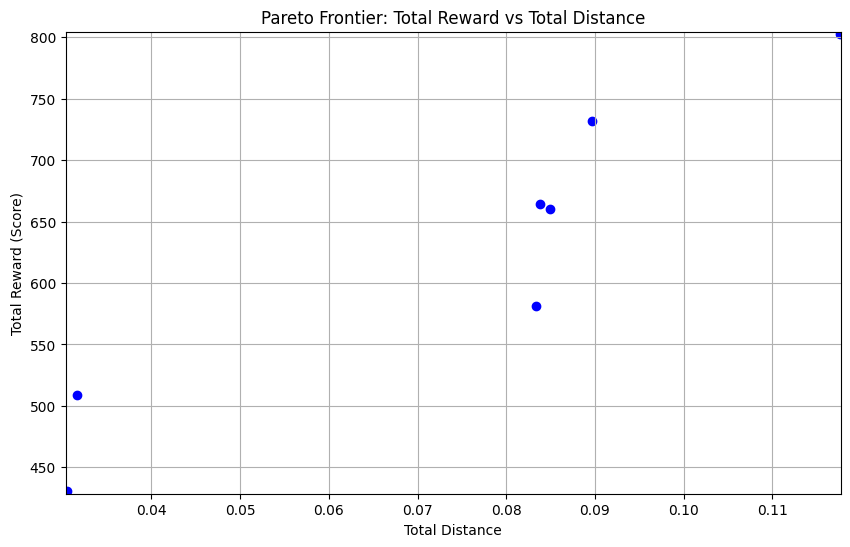

In [13]:
import matplotlib.pyplot as plt

def solve_ctop_with_pareto(num_nodes, num_vehicles, distances, scores, demands, vehicle_capacity, max_distance, coords, min_score_constraints):
    results = []
    
    for min_score_constraint in min_score_constraints:
        # 시작 시간 기록
        start_time = time.time()
        # Create the solver
        solver = pywraplp.Solver.CreateSolver('CBC')

        # Variables
        x = {}  # x[i, j, k] : Vehicle k travels from node i to node j
        y = {}  # y[i, k] : Vehicle k visits node i
        for i in range(num_nodes):
            for j in range(num_nodes):
                for k in range(num_vehicles):
                    x[i, j, k] = solver.BoolVar(f'x_{i}_{j}_{k}')
            for k in range(num_vehicles):
                y[i, k] = solver.BoolVar(f'y_{i}_{k}')

        # Objective: Minimize the travel distance
        solver.Minimize(
            solver.Sum(distances[i][j] * x[i, j, k] for i in range(num_nodes) for j in range(num_nodes) for k in range(num_vehicles))
        )

        # Constraints

        # 각 차량의 점수 제약 조건: 최소한 min_vehicle_score_constraint 이상이어야 합니다.
        for k in range(num_vehicles):
            vehicle_score = solver.Sum(scores[i] * y[i, k] for i in range(1, num_nodes))
            solver.Add(vehicle_score >= min_score_constraint)

        # 각 노드는 최대 한 번만 방문
        for i in range(1, num_nodes):
            solver.Add(solver.Sum(y[i, k] for k in range(num_vehicles)) <= 1)

        # 차량 용량 제한
        for k in range(num_vehicles):
            solver.Add(solver.Sum(demands[i] * y[i, k] for i in range(1, num_nodes)) <= vehicle_capacity[k])

        # 각 차량의 최대 이동 거리 제한
        for k in range(num_vehicles):
            solver.Add(solver.Sum(distances[i][j] * x[i, j, k] for i in range(num_nodes) for j in range(num_nodes)) <= max_distance[k])

        # 흐름 보존 제약 (Flow conservation constraint)
        for k in range(num_vehicles):
            for i in range(num_nodes):
                solver.Add(solver.Sum(x[i, j, k] for j in range(num_nodes) if j != i) == y[i, k])
                solver.Add(solver.Sum(x[j, i, k] for j in range(num_nodes) if j != i) == y[i, k])

        # 차량은 Depot (노드 0)에서 출발하고, 다시 돌아와야 합니다.
        for k in range(num_vehicles):
            solver.Add(solver.Sum(x[0, j, k] for j in range(1, num_nodes)) == 1)
            solver.Add(solver.Sum(x[i, 0, k] for i in range(1, num_nodes)) == 1)

        # 문제를 해결합니다.
        status = solver.Solve()

        # 해법 추출
        if status == pywraplp.Solver.OPTIMAL:
            total_score = 0
            total_distance = 0
            for k in range(num_vehicles):
                route = [0]
                for i in range(1, num_nodes):
                    if y[i, k].solution_value() > 0.5:
                        route.append(i)
                route.append(0)

                # 경로의 총 거리 계산
                distance = sum(distances[route[i]][route[i + 1]] for i in range(len(route) - 1))
                total_distance += distance
                
                # 각 경로의 총 점수 계산
                total_score += sum(scores[i] for i in route)
            
            # 각 해에 대한 보상 및 거리 기록
            results.append((total_score, total_distance))

    return results

# Pareto Optimal 해를 계산하여 플로팅하는 함수
def plot_pareto_frontier(results):
    scores = [result[0] for result in results]
    distances = [result[1] for result in results]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(distances, scores, c='blue')
    
    # X축과 Y축 범위를 더 좁게 설정 (확대 효과)
    plt.xlim(min(distances) - 0.0001, max(distances) + 0.0001)  # X축 범위를 더 좁게 설정
    plt.ylim(min(scores) - 2, max(scores) + 2)  # Y축 범위를 더 좁게 설정
    
    # Pareto Front 그리기
    plt.xlabel('Total Distance')
    plt.ylabel('Total Reward (Score)')
    plt.title('Pareto Frontier: Total Reward vs Total Distance')
    plt.grid(True)
    plt.show()


# ============================= #
# df4 데이터를 활용한 문제 정의   #
# ============================= #

# df4 데이터를 priority_score 기준으로 정렬하고 상위 150개의 노드만 선택합니다.
df_Dosan_split_final_sorted = df_Dosan_split_final.sort_values(by='priority_score', ascending=False).head(150)

# coords는 df4의 geometry에서 추출합니다. Depot 좌표 (129.3299, 35.5299)를 추가합니다.
coords = [(129.3299, 35.5299)] + [(point.x, point.y) for point in df_Dosan_split_final_sorted['geometry']]

# scores는 df4의 priority_score을 사용합니다.
scores = [0] + df_Dosan_split_final_sorted['priority_score'].tolist()  # Depot의 score는 0으로 설정

# demands는 df4의 demand를 사용합니다.
demands = [0] + df_Dosan_split_final_sorted['demand'].tolist()  # Depot의 demand는 0으로 설정

# 문제 정의
num_nodes = len(coords)
num_vehicles = 2
vehicle_capacity = [60, 60]
max_distance = [100, 100]

# 거리 계산
distances = calculate_distances(coords)

# 다양한 최소 점수 제약 설정
min_score_constraints = [200, 230, 260, 300, 330, 360, 400, 430, 460, 500, 530, 560]  # 예시로 여러 제약을 설정

# Pareto Optimal 결과 얻기
pareto_results = solve_ctop_with_pareto(num_nodes, num_vehicles, distances, scores, demands, vehicle_capacity, max_distance, coords, min_score_constraints)

# Pareto 그래프 출력
plot_pareto_frontier(pareto_results)
